In [2]:
# GPU-Accelerated Audio Feature Extraction with Fixed File Processing
# This notebook extracts features from audio files using GPU acceleration

# Install required packages

import os
import numpy as np
import pandas as pd
import librosa
import time
from tqdm import tqdm
import warnings
import tensorflow as tf  # For GPU verification
warnings.filterwarnings('ignore')

# Enable GPU acceleration for librosa where possible
os.environ['NUMBA_CACHE_DIR'] = '/tmp/numba_cache'
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # Use Kaggle's GPU

# Define feature extraction function
def extract_features(file_path, sample_rate=16000):
    """
    Extract audio features for deepfake detection with GPU acceleration.
    """
    try:
        # Load the audio file
        y, sr = librosa.load(file_path, sr=sample_rate)
        
        # Basic MFCC features
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
        mfccs_mean = np.mean(mfccs.T, axis=0)
        
        # Chroma features
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        chroma_mean = np.mean(chroma.T, axis=0)
        
        # Spectral features
        spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr)
        spectral_mean = np.mean(spectral_centroids.T, axis=0)
        
        # Zero crossing rate
        zcr = librosa.feature.zero_crossing_rate(y)
        zcr_mean = np.mean(zcr.T, axis=0)
        
        # Energy/RMS
        rms = librosa.feature.rms(y=y)
        rms_mean = np.mean(rms.T, axis=0)
        
        # Combine all features into a single vector
        features = np.concatenate([
            mfccs_mean,
            chroma_mean,
            spectral_mean,
            zcr_mean,
            rms_mean
        ])
        
        return features
    
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# FIXED VERSION: Process directory function (direct version without tqdm bug)
def process_directory(directory, label, batch_size=16):
    """
    Process all audio files in a directory using batched processing.
    Fixed version that properly handles file counts.
    """
    data = []
    labels = []
    filenames = []
    
    # Get all audio files
    audio_files = []
    for f in os.listdir(directory):
        if f.lower().endswith(('.wav', '.mp3', '.flac')):
            audio_files.append(os.path.join(directory, f))
    
    total_files = len(audio_files)
    print(f"Processing {total_files} audio files from {os.path.basename(directory)}...")
    
    # Process in batches - using direct loop to avoid tqdm issues
    processed = 0
    start_time = time.time()
    
    for i in range(0, total_files, batch_size):
        # Print progress manually
        if i % (batch_size * 10) == 0:
            elapsed = time.time() - start_time
            if elapsed > 0 and processed > 0:
                rate = processed / elapsed
                remaining = (total_files - processed) / rate if rate > 0 else 0
                print(f"Progress: {processed}/{total_files} files ({processed/total_files*100:.1f}%) - {rate:.2f} files/sec - Est. remaining: {remaining/60:.1f} min")
        
        # Process batch
        batch = audio_files[i:i+batch_size]
        batch_features = []
        batch_filenames = []
        
        for file_path in batch:
            features = extract_features(file_path)
            if features is not None:
                batch_features.append(features)
                batch_filenames.append(os.path.basename(file_path))
                processed += 1
        
        data.extend(batch_features)
        labels.extend([label] * len(batch_features))
        filenames.extend(batch_filenames)
    
    # Final progress
    elapsed = time.time() - start_time
    rate = processed / elapsed if elapsed > 0 else 0
    print(f"Completed: {processed}/{total_files} files processed in {elapsed:.1f} seconds ({rate:.2f} files/sec)")
    
    return data, labels, filenames

# Main processing function
def process_dataset(base_dir, output_dir="./extracted_features"):
    """
    Process the entire dataset structure.
    """
    os.makedirs(output_dir, exist_ok=True)
    
    # Find all subdivisions (training, validation, testing)
    for subset in ["training", "validation", "testing"]:
        subset_path = os.path.join(base_dir, subset)
        
        if not os.path.exists(subset_path):
            print(f"Subset {subset} not found at {subset_path}")
            continue
        
        # Process real and fake directories
        all_data = []
        all_labels = []
        all_filenames = []
        
        # Process real audio
        real_dir = os.path.join(subset_path, "real")
        if os.path.exists(real_dir):
            print(f"\nProcessing real audio in {subset}...")
            start_time = time.time()
            real_data, real_labels, real_filenames = process_directory(real_dir, label=0)
            all_data.extend(real_data)
            all_labels.extend(real_labels)
            all_filenames.extend(real_filenames)
            duration = time.time() - start_time
            print(f"Processed {len(real_data)} real audio files in {duration:.2f} seconds")
        
        # Process fake audio
        fake_dir = os.path.join(subset_path, "fake")
        if os.path.exists(fake_dir):
            print(f"\nProcessing fake audio in {subset}...")
            start_time = time.time()
            fake_data, fake_labels, fake_filenames = process_directory(fake_dir, label=1)
            all_data.extend(fake_data)
            all_labels.extend(fake_labels)
            all_filenames.extend(fake_filenames)
            duration = time.time() - start_time
            print(f"Processed {len(fake_data)} fake audio files in {duration:.2f} seconds")
        
        # Save to CSV if we have data
        if all_data:
            # Convert to DataFrame
            feature_cols = [f'feature_{i}' for i in range(len(all_data[0]))]
            df = pd.DataFrame(all_data, columns=feature_cols)
            df['label'] = all_labels
            df['filename'] = all_filenames
            
            # Save to CSV
            output_file = os.path.join(output_dir, f"{subset}_features.csv")
            df.to_csv(output_file, index=False)
            print(f"Saved {len(df)} samples to {output_file}")

# ----------------------------------------
# Main execution
# ----------------------------------------

# Set path to dataset
BASE_DIR = "../input/the-fake-or-real-dataset/for-2sec/for-2seconds"
OUTPUT_DIR = "./extracted_features"

# Print dataset summary (counts only)
print("Dataset summary:")
for subset in ["training", "validation", "testing"]:
    subset_path = os.path.join(BASE_DIR, subset)
    
    if not os.path.exists(subset_path):
        print(f"  - {subset}: Directory not found")
        continue
        
    print(f"  - {subset}:")
    
    # Check real directory
    real_dir = os.path.join(subset_path, "real")
    if os.path.exists(real_dir):
        real_files = [f for f in os.listdir(real_dir) if f.lower().endswith(('.wav', '.mp3', '.flac'))]
        print(f"    - real: {len(real_files)} audio files")
    
    # Check fake directory
    fake_dir = os.path.join(subset_path, "fake")
    if os.path.exists(fake_dir):
        fake_files = [f for f in os.listdir(fake_dir) if f.lower().endswith(('.wav', '.mp3', '.flac'))]
        print(f"    - fake: {len(fake_files)} audio files")

# Test extraction on a single file
print("\nTesting feature extraction on a sample file...")
test_file = None
for root, dirs, files in os.walk(BASE_DIR):
    for file in files:
        if file.lower().endswith(('.wav', '.mp3', '.flac')):
            test_file = os.path.join(root, file)
            break
    if test_file:
        break

if test_file:
    print(f"Testing with {test_file}")
    features = extract_features(test_file)
    if features is not None:
        print(f"Success! Extracted {len(features)} features.")
        print(f"Feature shape: {features.shape}")
        print("Starting full extraction...")
        
        # Run the full feature extraction
        process_dataset(BASE_DIR, OUTPUT_DIR)
        
        # Create zip file of features for download
        print("\nCreating zip file...")
        !zip -r extracted_features.zip {OUTPUT_DIR}
        
        print("\nFeature extraction complete!")
        print("You can now download the zip file from the output tab.")
    else:
        print("Feature extraction test failed.")
else:
    print("No audio files found for testing.")

KeyboardInterrupt: 

In [7]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import joblib

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [8]:
# Set the path to your CSV files - update this to where you extracted the zip file
data_dir = "extracted_features"

# Load the CSV files
print("Loading data...")
train_data = pd.read_csv(os.path.join(data_dir, 'training_features.csv'))
val_data = pd.read_csv(os.path.join(data_dir, 'validation_features.csv'))
test_data = pd.read_csv(os.path.join(data_dir, 'testing_features.csv'))

# Check the data
print(f"Training data shape: {train_data.shape}")
print(f"Validation data shape: {val_data.shape}")
print(f"Test data shape: {test_data.shape}")

# Display sample data
train_data.head()

Loading data...
Training data shape: (13956, 57)
Validation data shape: (2826, 57)
Test data shape: (1088, 57)


,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,label,filename
0,-195.640671,167.910507,-70.272766,39.673054,5.309880,-21.347656,1.462397,-37.625446,-15.222323,-8.965453,...,0.407468,0.525411,0.460758,0.287813,0.302367,1057.705676,0.108755,0.118057,0,file26954.wav_16k.wav_norm.wav_mono.wav_silenc...
1,-134.341339,123.963821,-18.347830,38.309132,-1.361740,-8.420963,16.068312,-8.472509,-4.602731,-1.791206,...,0.354793,0.463510,0.402069,0.334473,0.419588,1308.476998,0.079350,0.171972,0,file20661.wav_16k.wav_norm.wav_mono.wav_silenc...
2,-249.453308,62.038654,5.144326,2.348206,-14.346089,-16.478830,-23.544563,-20.526354,1.442770,-18.709812,...,0.255598,0.254178,0.444404,0.503706,0.464341,2449.924753,0.220618,0.087257,0,file1603.wav_16k.wav_norm.wav_mono.wav_silence...
3,-175.063461,90.332993,-11.622402,-7.943896,-31.781181,-19.183908,-24.660803,-22.064539,-1.707203,-13.132598,...,0.223217,0.249099,0.384171,0.467234,0.369766,2030.904568,0.196553,0.128912,0,file8436.wav_16k.wav_norm.wav_mono.wav_silence...
4,-185.658524,84.165359,18.263103,31.042599,-12.358898,7.237917,-15.485649,-9.498494,-12.813581,-7.642183,...,0.444537,0.516055,0.330328,0.124928,0.063767,1599.921676,0.115320,0.259067,0,file11300.wav_16k.wav_norm.wav_mono.wav_silenc...


In [9]:
# Check class distribution
print("Class distribution:")
print("Training set:")
print(train_data['label'].value_counts())
print("\nValidation set:")
print(val_data['label'].value_counts())
print("\nTest set:")
print(test_data['label'].value_counts())

Class distribution:
Training set:
label
0    6978
1    6978
Name: count, dtype: int64

Validation set:
label
0    1413
1    1413
Name: count, dtype: int64

Test set:
label
0    544
1    544
Name: count, dtype: int64


In [10]:
# Separate features from labels
feature_cols = [col for col in train_data.columns if col.startswith('feature_')]
print(f"Number of features: {len(feature_cols)}")

X_train = train_data[feature_cols].values
y_train = train_data['label'].values
X_val = val_data[feature_cols].values
y_val = val_data['label'].values
X_test = test_data[feature_cols].values
y_test = test_data['label'].values

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Number of features: 55
Training set: 13956 samples
Validation set: 2826 samples
Test set: 1088 samples


In [11]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Save the scaler
joblib.dump(scaler, 'audio_deepfake_scaler.pkl')
print("Scaler saved to 'audio_deepfake_scaler.pkl'")

Scaler saved to 'audio_deepfake_scaler.pkl'


In [13]:
# # Analyze a few important features
# def plot_feature_distributions(feature_idx, feature_name):
#     plt.figure(figsize=(12, 5))
    
#     plt.subplot(1, 2, 1)
#     sns.histplot(X_train[y_train==0, feature_idx], label='Real', alpha=0.6, color='blue')
#     sns.histplot(X_train[y_train==1, feature_idx], label='Fake', alpha=0.6, color='red')
#     plt.title(f"{feature_name} Distribution")
#     plt.xlabel(feature_name)
#     plt.legend()
    
#     plt.subplot(1, 2, 2)
#     sns.boxplot(x=train_data['label'], y=train_data[f'feature_{feature_idx}'])
#     plt.title(f"{feature_name} by Class")
#     plt.xticks([0, 1], ['Real', 'Fake'])
#     plt.xlabel('Class')
#     plt.ylabel(feature_name)
    
#     plt.tight_layout()
#     plt.show()

# # Plot a few interesting features
# plot_feature_distributions(0, "MFCC 1")
# plot_feature_distributions(1, "MFCC 2")
# plot_feature_distributions(40, "Chroma 1")
# plot_feature_distributions(52, "Spectral Centroid")
# plot_feature_distributions(53, "Zero Crossing Rate")
# plot_feature_distributions(54, "RMS Energy")

In [14]:
# Build model
def build_model(input_shape):
    model = Sequential([
        # Input layer
        Dense(256, activation='relu', input_shape=(input_shape,)),
        BatchNormalization(),
        Dropout(0.3),
        
        # Hidden layers
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        
        # Output layer
        Dense(1, activation='sigmoid')
    ])
    
    # Compile model
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Create the model
model = build_model(X_train_scaled.shape[1])
model.summary()

I0000 00:00:1744527974.490777      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │          14,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 57,345 (224.00 KB)

 Trainable params: 56,449 (220.50 KB)

 Non-trainable params: 896 (3.50 KB)

I0000 00:00:1744528055.764850     135 service.cc:148] XLA service 0x7fef80008120 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744528055.765937     135 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1744528056.044126     135 cuda_dnn.cc:529] Loaded cuDNN version 90300


34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8550 - loss: 0.5526


I0000 00:00:1744528056.853871     135 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Test accuracy: 0.6287
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  

Classification Report:
              precision    recall  f1-score   support

        Real       0.58      0.97      0.72       544
        Fake       0.90      0.29      0.44       544

    accuracy                           0.63      1088
   macro avg       0.74      0.63      0.58      1088
weighted avg       0.74      0.63      0.58      1088



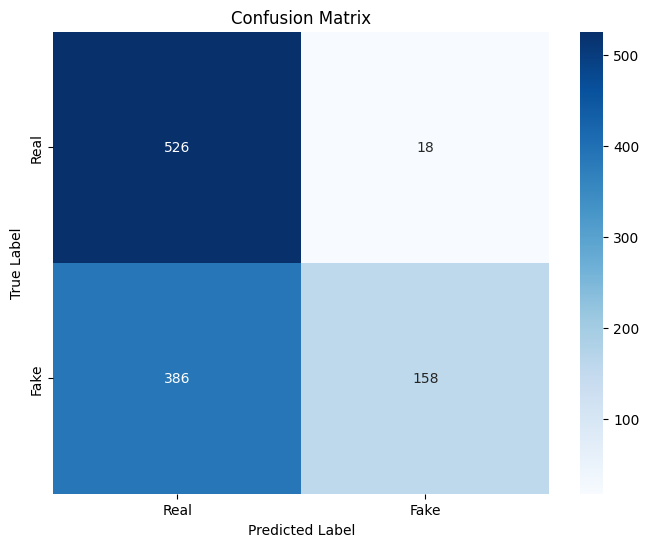

In [16]:
# Evaluate on test set
test_loss, test_acc = model.evaluate(X_test_scaled, y_test)
print(f"Test accuracy: {test_acc:.4f}")

# Generate predictions
y_pred_prob = model.predict(X_test_scaled)
y_pred = (y_pred_prob > 0.5).astype(int)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Real', 'Fake']))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=['Real', 'Fake'],
           yticklabels=['Real', 'Fake'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.show()

In [6]:
# Save the model
model.save('audio_deepfake_detector.h5')
print("Model saved to 'audio_deepfake_detector.h5'")

NameError: name 'model' is not defined

In [1]:
import librosa
import tensorflow as tf

def extract_features(file_path, sample_rate=16000):
    """Extract the same features used during training."""
    try:
        # Load the audio file
        y, sr = librosa.load(file_path, sr=sample_rate)
        
        # Extract features (same as in your training script)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
        mfccs_mean = np.mean(mfccs.T, axis=0)
        
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        chroma_mean = np.mean(chroma.T, axis=0)
        
        spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr)
        spectral_mean = np.mean(spectral_centroids.T, axis=0)
        
        zcr = librosa.feature.zero_crossing_rate(y)
        zcr_mean = np.mean(zcr.T, axis=0)
        
        rms = librosa.feature.rms(y=y)
        rms_mean = np.mean(rms.T, axis=0)
        
        # Combine all features
        features = np.concatenate([
            mfccs_mean,
            chroma_mean,
            spectral_mean,
            zcr_mean,
            rms_mean
        ])
        
        return features
    
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

def predict_audio(file_path, model_path='audio_deepfake_detector.h5', scaler_path='audio_deepfake_scaler.pkl'):
    """Predict if an audio file is real or AI-generated."""
    # Load model and scaler
    model = tf.keras.models.load_model(model_path)
    scaler = joblib.load(scaler_path)
    
    # Extract features
    features = extract_features(file_path)
    if features is None:
        return "Error: Could not process the audio file"
    
    # Scale features
    features_scaled = scaler.transform([features])
    
    # Predict
    prediction = model.predict(features_scaled)[0][0]
    predicted_label = 1 if prediction > 0.5 else 0
    confidence = prediction if predicted_label == 1 else 1 - prediction
    
    label_map = {0: "Real", 1: "AI-Generated/Fake"}
    
    result = {
        "prediction": label_map[predicted_label],
        "confidence": float(confidence * 100),
        "prob_real": float((1 - prediction) * 100),
        "prob_fake": float(prediction * 100)
    }
    
    return result

In [2]:
# To test the prediction function, replace with the path to your test audio file
test_file = "/Users/arjun.maniyani/Desktop/PESU/Class/DL/project/ai_audio_detection/anish.wav"  # Replace with actual path
result = predict_audio(test_file)
print(f"Prediction: {result['prediction']}")
print(f"Confidence: {result['confidence']:.2f}%")
print(f"Probability - Real: {result['prob_real']:.2f}%, Fake: {result['prob_fake']:.2f}%")

NameError: name 'joblib' is not defined